In [7]:

import pandas as pd 
import numpy as np 
from utils import * 
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from src.classifier import Classifier
import seaborn as sns 
import matplotlib.pyplot as plt
import glob
import os
import dataframe_image as dfi
import warnings
warnings.simplefilter('ignore')

%load_ext autoreload
%autoreload 2

confusion_matrix_map = {'tp':'true positive', 'fp':'false positive', 'tn':'true negative', 'fn':'false negative'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
test_results_df = pd.read_csv('../data/results/dataset_test_predict.csv', index_col=0)
test_results_df = test_results_df.merge(pd.read_csv('../data/datasets/dataset_test.csv', index_col=0), left_index=True, right_index=True, how='left')

train_results_df = pd.read_csv('../data/results/dataset_train_predict.csv', index_col=0)
train_results_df = train_results_df.merge(pd.read_csv('../data/datasets/dataset_train.csv', index_col=0), left_index=True, right_index=True, how='left')

In [17]:
results_df = pd.concat([train_results_df, test_results_df])

In [10]:
results_df['product'].value_counts()

product
Uncharacterized protein                                    11523
DUF3265 domain-containing protein                           2269
DNA ligase                                                   700
Ribosomal RNA small subunit methyltransferase H              697
Polyribonucleotide nucleotidyltransferase                    659
                                                           ...  
UPF0301 protein Psyr_0485                                      1
Uncharacterized protein RP568                                  1
Uncharacterized HTH-type transcriptional regulator YozG        1
UPF0435 protein BPUM_0734                                      1
UPF0303 protein Arad_3071                                      1
Name: count, Length: 35643, dtype: int64

In [11]:
def table_1(results_df:pd.DataFrame, path:str=None):

    model_names = [os.path.basename(path).replace('.pkl', '') for path in glob.glob('../models/*pkl')]

    table_df = list()
    for model_name in model_names:
        row = dict()
        row['model_name'] = model_name

        tn, fp, fn, tp = confusion_matrix(results_df['label'], results_df[f'{model_name}_label']).ravel()
        row['true_positive'] = tp
        row['true_negative'] = tn
        row['false_positive'] = fp
        row['false_negative'] = fn
        row['accuracy'] = np.round(balanced_accuracy_score(results_df.label, results_df[f'{model_name}_label']), 4)
        table_df.append(row)

    table_df = pd.DataFrame(table_df).set_index('model_name')
    table_df = table_df.sort_values('false_positive')

    # dfi.export(table_df, path, table_conversion='matplotlib')
    return table_df

table_1(results_df)


,true_positive,true_negative,false_positive,false_negative,accuracy
model_name,,,,,
model_v1,257997,19480,7,1099,0.9977
model_v2,258373,19477,10,723,0.9983
model_v3,258512,19474,13,584,0.9985


In [18]:
model_name = 'model_v3'
train_results_df = train_results_df.rename(columns={col:col.replace(model_name, 'model') for col in train_results_df.columns})
test_results_df = test_results_df.rename(columns={col:col.replace(model_name, 'model') for col in test_results_df.columns})
results_df = results_df.rename(columns={col:col.replace(model_name, 'model') for col in results_df.columns})

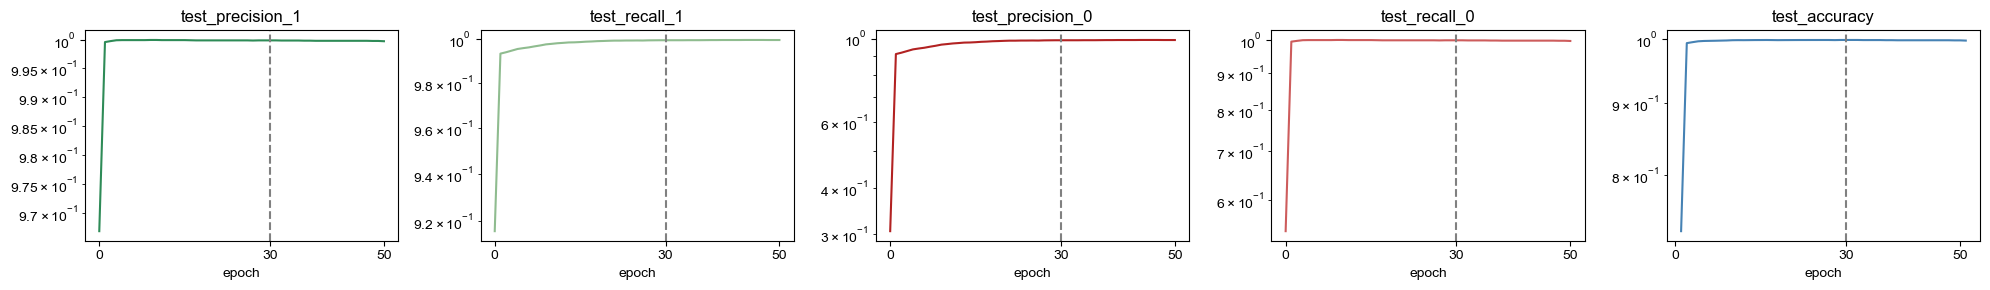

In [29]:
model = Classifier.load('../models/model_v3.pkl')

def figure_1(model:Classifier, path:str=None, metrics:list=['test_precision_1', 'test_recall_1', 'test_precision_0', 'test_recall_0', 'test_accuracy']):
    
    colors = dict()
    colors['test_precision_1'] = 'seagreen'
    colors['test_recall_1'] = 'darkseagreen'
    colors['test_precision_0'] = 'firebrick'
    colors['test_recall_0'] = 'indianred'
    colors['test_accuracy'] = 'steelblue'

    fig, axes = plt.subplots(ncols=len(metrics), figsize=(4 * len(metrics), 3))
    
    for ax, metric in zip(axes, metrics):
        ax.set_title(metric)
        ax = sns.lineplot(x=np.arange(len(model.metrics[metric])), y=model.metrics[metric], label=metric, color=colors[metric], ax=ax, legend=False)
        ax.axvline(x=model.best_epoch, color='gray', linestyle='--')

        xticks = sorted(list(range(0, model.epochs + 1, 50)) + [model.best_epoch])
        ax.set_xticks(xticks, labels=xticks)
        ax.set_xlabel('epoch')
        ax.set_yscale('log')
        
    fig.tight_layout()
    plt.show()

figure_1(model)

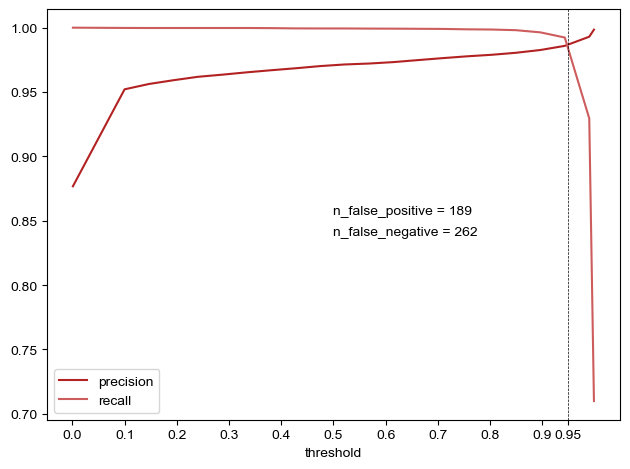

In [30]:
def figure_2(results_df, threshold:float=0.99):

    min_threshold = results_df.model_output_0.min() + 1e-3
    max_threshold = results_df.model_output_0.max() - 1e-3

    thresholds = [min_threshold] + list(np.linspace(0.1, 0.99, 20)) + [max_threshold]
    ax_df = pd.DataFrame(index=np.arange(len(thresholds)))
    ax_df['threshold'] = thresholds
    ax_df['precision'] = [precision(results_df, class_=0, threshold=threshold) for threshold in thresholds]
    ax_df['recall'] = [recall(results_df, class_=0, threshold=threshold) for threshold in thresholds]

    fig, ax = plt.subplots()

    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='precision', label='precision', color='firebrick')
    sns.lineplot(data=ax_df, ax=ax, x='threshold', y='recall', label='recall', color='indianred')
    ax.axvline(threshold, color='black', linewidth=0.5, linestyle='--')

    n_fn = ((results_df.model_output_0 > threshold) & (results_df.label == 1)).sum()
    n_fp = ((results_df.model_output_0 <= threshold) & (results_df.label == 0)).sum()
    ax.text(0.5, 0.5, f'n_false_positive = {n_fp}', transform=ax.transAxes)
    ax.text(0.5, 0.45, f'n_false_negative = {n_fn}', transform=ax.transAxes)

    ax.set_ylabel('')
    x_ticks = sorted(list(np.arange(10) / 10) + [threshold])
    ax.set_xticks(x_ticks, labels=x_ticks)

    fig.tight_layout()
    plt.show()

figure_2(results_df, threshold=0.95)

# False negative is when a sequence is classified spurious, but is real (these are the most concerning)
# False positive is when a sequence is classified real, but is spurious. 

In [ ]:
threshold = 0.95
results_df['model_label'] = np.where(results_df.model_output_0 > threshold, 0, 1)

fp_results_df = results_df[(results_df.model_label == 1) & (results_df.label == 0)].copy()
fn_results_df = results_df[(results_df.model_label == 0) & (results_df.label == 1)].copy()

In [30]:
error_cluster_ids = results_df[results_df.model_label != results_df.label].cluster_id.unique()

cluster_df = pd.read_csv('../data/datasets/dataset_cluster.csv', index_col=0)
cluster_df = cluster_df[cluster_df.cluster_id.isin(error_cluster_ids)].copy()

cluster_results_df = pd.DataFrame(index=pd.Index(error_cluster_ids, name='cluster_id'))
cluster_results_df['size'] = cluster_df.groupby('cluster_id').apply(len, include_groups=False)
cluster_results_df['n_errors'] = results_df[results_df.model_label != results_df.label].groupby('cluster_id').apply(len, include_groups=False)
cluster_results_df['frac_errors'] = cluster_results_df.n_errors / cluster_results_df['size']
cluster_results_df['annotation'] = annotate_clusters(results_df)


In [69]:
results_df[results_df.cluster_id == 4688][['product']]

,product
id,
A0A329HQH8,DUF2684 domain-containing protein
A0A7L6VMH5,Uncharacterized protein
A0AAE8R036,DUF2684 family protein


In [32]:
cluster_results_df[cluster_results_df.annotation != 'none']

,size,n_errors,frac_errors,annotation
cluster_id,,,,
33031,11,1,0.090909,"ATP-binding protein SyrD,Cell division protein..."
6185,2,2,1.000000,Uncharacterized protein
5615,3,1,0.333333,Light-harvesting protein B-800/820 alpha chain...
804,4,2,0.500000,"Cytochrome bd ubiquinol oxidase subunit X,Ligh..."
5662,3,3,1.000000,"Protein YecU,Uncharacterized protein"
...,...,...,...,...
16506,9,1,0.111111,"6-carboxyhexanoate--CoA ligase,D-aminoacyl-tRN..."
4517,3,1,0.333333,Tyr recombinase domain-containing protein
21623,10,1,0.100000,"2-epi-valiolone synthase,Actinorhodin polyketi..."


In [36]:
results_df[results_df.cluster_id == 33031][['ncbifam_description']]

,ncbifam_description
id,
Q02541,cztS_silS_copS
Q748D9,none
I1WSZ3,cztS_silS_copS
P0DMK6,cztS_silS_copS
Q9ZHD4,cztS_silS_copS
Q44007,cztS_silS_copS
Q8X614,none
P14377,none
P33951,cyc_pep_trnsptr


In [34]:
results_df.columns

Index(['model_label', 'model_output_0', 'model_output_1', 'model_v2_label',
       'model_v2_output_0', 'model_v2_output_1', 'model_v1_label',
       'model_v1_output_0', 'model_v1_output_1', 'cluster_id', 'antifam_name',
       'antifam_id', 'product', 'ncbi_taxonomy_id', 'organism', 'seq',
       'lineage', 'library_entry_name', 'label', 'refseq_protein_id',
       'refseq_nucleotide_id', 'non_terminal_residue', 'function',
       'post_translational_modification', 'pfam_description', 'pfam_id',
       'interpro_description', 'interpro_id', 'ncbifam_description',
       'ncbifam_id', 'panther_description', 'panther_id', 'supfam_description',
       'supfam_id', 'gene3d_description', 'gene3d_id', 'kegg_description',
       'kegg_id', 'existence', 'name', 'file_name', 'domain', 'phylum',
       'class', 'order', 'family', 'genus', 'species'],
      dtype='object')

In [29]:
def annotate_clusters(results_df:pd.DataFrame):
    annotations = dict()
    for cluster_id, df in results_df.groupby('cluster_id'):
        # cluster_annotations = df['product'].replace({'Uncharacterized protein':'none'}).unique()
        cluster_annotations = df['product'].apply(lambda product : 'Uncharacterized protein' if ('uncharacterized' in product.lower()) else product)
        cluster_annotations = np.unique(cluster_annotations)
        cluster_annotations = ','.join(list(cluster_annotations))
        annotations[cluster_id] = cluster_annotations 
    return pd.Series(annotations)

In [64]:
annotate_clusters(results_df)

0        none
1        none
2        none
3        none
4        none
         ... 
49995    none
49996    none
49997    none
49998    none
49999    none
Length: 50000, dtype: object

In [11]:
# What are the proteins it struggles on?

# def figure(results_df:pd.DataFrame, threshold:float=0.95):

#     results_df = results_df.copy()

#     fig, ax = plt.subplots()

#     # sns.kdeplot(ax=ax, data=results_df[results_df.model_label == 1].seq.apply(len))
#     # sns.kdeplot(ax=ax, data=results_df[results_df.model_label == 0].seq.apply(len))
#     # sns.kdeplot(ax=ax, data=fp_results_df.seq.apply(len))
#     # sns.kdeplot(ax=ax, data=fn_results_df.seq.apply(len))

#     plt.show()

#     return fp_results_df, fn_results_df



In [12]:
fn_results_df.seq.apply(len).mean()
fp_results_df.seq.apply(len).mean()

np.float64(95.22222222222223)

In [13]:
results_df.seq.apply(len).mean()

np.float64(315.1821862784161)

In [14]:
results_df[results_df.label == 0].seq.apply(len).mean()

np.float64(166.97018525170625)

In [15]:
fp_results_df

,model_label,model_output_0,model_output_1,model_v2_label,model_v2_output_0,model_v2_output_1,model_v1_label,model_v1_output_0,model_v1_output_1,antifam_name,...,kegg,file_name,domain,phylum,class,order,family,genus,species,cluster_id
id,,,,,,,,,,,,,,,,,,,,,
A0A2H6ADC5,1,0.943531,0.056469,0,0.977635,0.022365,0,0.986667,0.013333,Shadow ORF (opposite leuS),...,none,none,Bacteria,none,none,none,none,none,bacterium HR36,29433
A0A0H3B5W2,1,0.949893,0.050107,0,0.955236,0.044764,0,0.973400,0.026600,Translation of DNA tandem repeat,...,none,none,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Yersinia,Yersinia pseudotuberculosis,39708
A0A857F6C1,1,0.936801,0.063199,0,0.937762,0.062238,0,0.948728,0.051272,Protein of unknown function (DUF2575),...,none,none,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Yersiniaceae,Yersinia,Yersinia canariae,2913
A0A8B3JQU5,1,0.939838,0.060162,0,0.935253,0.064748,0,0.938695,0.061305,Protein of unknown function (DUF2575),...,none,none,Bacteria,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Enterobacter,Enterobacter sp. WCHEn090032,1338
A0A1B2YQK5,1,0.848133,0.151867,0,0.965499,0.034501,0,0.963528,0.036472,Antisense to 23S rRNA,...,none,none,Bacteria,none,none,none,none,none,uncultured bacterium,3777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A0A1I5C0G0,1,0.932525,0.067475,0,0.972814,0.027186,0,0.977199,0.022801,Shadow ORF (opposite ABC transporters),...,none,none,Bacteria,Pseudomonadota,Alphaproteobacteria,Hyphomicrobiales,Nitrobacteraceae,Bradyrhizobium,Bradyrhizobium sp. Rc3b,4963
I1ZKU7,1,0.940282,0.059718,0,0.926827,0.073173,0,0.982894,0.017106,Shadow ORF (opposite ABC transporter protein),...,none,none,Bacteria,Bacillota,Bacilli,Lactobacillales,Streptococcaceae,Streptococcus,Streptococcus parasanguinis,4141
A0A2N9MKG5,1,0.779071,0.220929,0,0.871251,0.128749,0,0.941939,0.058061,tRNA translation,...,none,none,Bacteria,Acidobacteriota,Terriglobia,Bryobacterales,Solibacteraceae,Candidatus Sulfopaludibacter,Candidatus Sulfopaludibacter sp. SbA6,2622
